# MeOH synthesis model comparison (Grabow vs RMG)

Source for grabow model:  
Grabow, L. C., & Mavrikakis, M. (2011). Mechanism of methanol synthesis on cu through CO2 and CO hydrogenation. ACS Catalysis, 1(4), 365–384. https://doi.org/10.1021/cs200055d

In [3]:
import pandas as pd
import numpy as np
import time
import cantera as ct
from matplotlib import pyplot as plt
import csv
import math
import os
import sys
from IPython.display import Image

import itertools
import logging
from collections import defaultdict

import scipy.linalg as la

print("Running Cantera version: {}".format(ct.__version__))

Running Cantera version: 2.6.0a1


In [2]:
# os.remove("Results_single.csv")
# Grabow model and RMG input files
# cti_file_rmg = 'Grabow_species_removed/chem_annotated_removed.cti'
cti_file_rmg = "/work/westgroup/ChrisB/meoh-synthesis_RMG/meOH-synthesis/base/cantera/chem_annotated.cti"

# Multipliers
cat_mult = 100

# constants
pi = math.pi

# set initial temps, pressures, concentrations
# temp = 230+273.15         # [kelvin]
temp = 528  # 483.5                # [kelvin]
pressure = 15.3 * 1e5  # [Pascals]
X_co = 0.025
X_co2 = 0.025
X_h2 = 0.95
mw_co = 28.01e-3  # [kg/mol]
mw_co2 = 44.01e-3  # [kg/mol]
mw_h2 = 1.01e-3  # [kg/mol]

# CO/CO2/H2/H2O: typical is
concentrations_rmg = {"CO(3)": X_co, "CO2(4)": X_co2, "H2(2)": X_h2}

# initialize cantera gas and surface
gas = ct.Solution(cti_file_rmg, "gas")

# surf_grab = ct.Interface(cti_file,'surface1_grab', [gas_grab])
surf = ct.Interface(cti_file_rmg, "surface1", [gas])

# gas_grab.TPX =
gas.TPX = temp, pressure, concentrations_rmg
surf.TP = temp, pressure
surf.coverages = "X(1):1.0"

# create gas inlet
inlet = ct.Reservoir(gas)

# create gas outlet
exhaust = ct.Reservoir(gas)

# Reactor volume
rradius = 35e-3
rlength = 70e-3
rvol = (rradius ** 2) * pi * rlength

# Catalyst Surface Area
site_density = (
    surf.site_density * 1000
)  # [mol/m^2]cantera uses kmol/m^2, convert to mol/m^2
cat_weight = 4.24e-3  # [kg]
cat_site_per_wt = (300 * 1e-6) * 1000  # [mol/kg] 1e-6mol/micromole, 1000g/kg
cat_area = cat_mult * site_density / (cat_weight * cat_site_per_wt)  # [m^3]

# reactor initialization
r = ct.IdealGasConstPressureReactor(gas, energy="off")
# r = ct.IdealGasReactor(gas, energy='off')
rsurf = ct.ReactorSurface(surf, r, A=cat_area)
r.volume = rvol


# flow controllers (Graaf measured flow at 293.15 and 1 atm)
one_atm = ct.one_atm
FC_temp = 293.15
volume_flow = 4.24e-3  # [m^3/s]
molar_flow = volume_flow * one_atm / (8.3145 * FC_temp)  # [mol/s]
mass_flow = molar_flow * (X_co * mw_co + X_co2 * mw_co2)  # [kg/s]
mfc = ct.MassFlowController(inlet, r, mdot=mass_flow)

# initialize reactor network
sim = ct.ReactorNet([r])

# set relative and absolute tolerances on the simulation
sim.rtol = 1.0e-11
sim.atol = 1.0e-22

# for debugging
sim.verbose = True
sim.reinitialize()


print(cat_area)

CanteraError: 
***********************************************************************
CanteraError thrown by call_ctml_writer:
Error converting input file "/work/westgroup/ChrisB/meoh-synthesis_RMG/meOH-synthesis/base/cantera/chem_annotated.cti" to CTML.
Python command was: '/home/blais.ch/.conda/envs/cantera/bin/python'
The exit code was: 1
-------------- start of converter log --------------
sys.path: ['', '/home/blais.ch/.conda/envs/cantera/lib/python3.8/site-packages', '/home/blais.ch/RMG_Base_env/RMG-Py', '/home/blais.ch/RMG_HAN_env/RMG-Py', '/home/blais.ch/RMG_HAN_env_Richard/RMG-Py', '/home/blais.ch/RMG_base_env_2/RMG-Py', '/work/westgroup/ChrisB/meOH-synthesis_cantera/meOH-synthesis/cantera_simulations/RMG_wDeut', '/shared/centos7/gaussian/gauopen', '/shared/centos7/gaussian/g16/bsd', '/shared/centos7/gaussian/g16', '/home/blais.ch/.conda/envs/cantera/lib/python38.zip', '/home/blais.ch/.conda/envs/cantera/lib/python3.8', '/home/blais.ch/.conda/envs/cantera/lib/python3.8/lib-dynload']

Traceback (most recent call last):
  File "<stdin>", line 5, in <module>
  File "/home/blais.ch/.conda/envs/cantera/lib/python3.8/site-packages/cantera/__init__.py", line 4, in <module>
    from ._cantera import *
  File "interfaces/cython/cantera/_cantera.pyx", line 1, in init cantera._cantera
ModuleNotFoundError: No module named 'numpy'
--------------- end of converter log ---------------
***********************************************************************


In [98]:
gas.species_names

['N2', 'Ne', 'H2(2)', 'CO(3)', 'CO2(4)', 'H2O(5)', 'CH2O(6)', 'HCOOH(7)', 'CH3OH(8)', 'HCOOCH3(9)']

### Replacing or perturbing thermo: 
it is as easy as adding in a new Nasa polynomial object, and replacing the old one with it. 

In [114]:
def peturb_thermo(phase, species, dH=1e-4):
    S = phase.species(species)
    thermo_orig = S.thermo
    coeffs = thermo_orig.coeffs
    coeffs[[6, 13]] += dH / ct.gas_constant
    thermo_new = ct.NasaPoly2(
        thermo_orig.min_temp,
        thermo_orig.max_temp,
        thermo_orig.reference_pressure,
        coeffs,
    )
    S.thermo = thermo_new
    phase.modify_species(phase.species_index(species), S)

    return thermo_orig


sens_species = "CH3OH(8)"
S_sens = gas.species(sens_species)
thermo_orig = peturb_thermo(phase=surf, species="X(1)", dH=1e-4)

print(sim.time)
time = []
conc = []
while sim.time < 20.0:
    time.append(sim.time)
    conc.append(gas.concentrations[gas.species_index(sens_species)])
    sim.step()

conc = np.array(conc)
time = np.array(time)
surf.species("X(1)").thermo = thermo_orig
sensitivity = (time[-1] * conc[-1] - np.trapz(conc, time)) / (conc[-1] - conc[0])

0.0
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a


In [115]:
print(sensitivity)

0.08298824770661534


<AxesSubplot:xlabel='time(s)'>

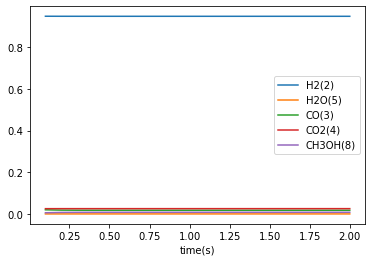

In [78]:
output_filename = f"Results_single.csv"
outfile = open(output_filename, "w")
writer = csv.writer(outfile)
writer.writerow(
    ["time(s)", "T (C)", "P (atm)", "gas density"]
    + gas.species_names
    + surf.species_names,
)

t = 0.0
dt = 0.1

# Setup solution array"
states = ct.SolutionArray(gas, extra=["t"])


while t < 20.0:
    t += dt

    sim.advance(t)
    writer.writerow(
        [t, temp, pressure, gas.density] + list(gas.X) + list(surf.X),
    )

results = pd.read_csv("Results_single.csv")
results.plot("time(s)", ["H2(2)", "H2O(5)", "CO(3)", "CO2(4)", "CH3OH(8)"])

In [ ]:
results.plot("time(s)", ["gas density"])

In [ ]:
sim.advance_to_steady_state(
    max_steps=100000, residual_threshold=sim.rtol * 2, return_residuals=True
)
writer.writerow(
    [temp, pressure, "V (M^3/s)", "X_co initial", "X_co initial", "X_co initial", gas.T]
    + list(gas.X)
    + list(surf.X),
)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

results = pd.read_csv("Results_single.csv")
max_dist = 2
imp_reactions = []
imprxn_max = []
imprxn_min = []

df_short = results

print("\n Reactions with ROP that spikes between 1.5 and 1.8:", "\n")
for i in range(6, len(df_short.columns)):

    column = df_short[df_short.columns[i]]
    dist = df_short[df_short.columns[0]]
    max_value = column.max()
    max_index = column.idxmax()
    min_value = column.min()
    min_index = column.idxmin()

    # 1.5 <= dist[min_index] <= 1.74 and
    if max_value >= 1e-4 and (
        ("X" in df_short.columns[i])
        or ("Pt" in df_short.columns[i])
        or ("Pd" in df_short.columns[i])
        or ("*" in df_short.columns[i])
    ):

        imp_reactions.append(df_short.columns[i])
        imprxn_max.append(max_value)
        imprxn_min.append(min_value)
        print(df_short.columns[i], "Max = " "{:.10f}".format(max_value))

    elif min_value <= -1e-4 and (
        ("X" in df_short.columns[i])
        or ("Pt" in df_short.columns[i])
        or ("Pd" in df_short.columns[i])
        or ("*" in df_short.columns[i])
    ):

        imp_reactions.append(df_short.columns[i])
        print(df_short.columns[i], "Min = " "{:.10f}".format(min_value))
        imprxn_max.append(max_value)
        imprxn_min.append(min_value)

In [ ]:
results.plot("time(s)", ["CO*(14)", "X(1)", "CH3OH(8)"])
print(gas.X)

In [ ]:
def save_flux_diagrams(*phases, suffix=""):
    """
    Saves the flux diagrams. The filenames have a suffix if provided,
    so you can keep them separate and not over-write.
    """
    for element in "CHONX":
        for phase_object in phases:
            phase = phase_object.name

            diagram = ct.ReactionPathDiagram(phase_object, element)
            diagram.title = f"Reaction path diagram following {element} in {phase}"
            diagram.label_threshold = 0.01

            dot_file = (
                f"reaction_path_{element}_{phase}{'_' if suffix else ''}{suffix}.dot"
            )
            img_file = (
                f"reaction_path_{element}_{phase}{'_' if suffix else ''}{suffix}.png"
            )
            img_path = os.path.join(os.getcwd(), img_file)
            diagram.write_dot(dot_file)
            # print(diagram.get_data())

            print(
                f"Wrote graphviz input file to '{os.path.join(os.getcwd(), dot_file)}'."
            )
            os.system(f"dot {dot_file} -Tpng -o{img_file} -Gdpi=200")
            print(f"Wrote graphviz output file to '{img_path}'.")


def show_flux_diagrams(*phases, suffix="", embed=False):
    """
    Shows the flux diagrams in the notebook.
    Loads them from disk.
    Does not embed them, to keep the .ipynb file small,
    unless embed=True. Use embed=True if you might over-write the files,
    eg. you want to show flux at different points.
    """
    import IPython

    for element in "CHONX":
        for phase_object in phases:
            phase = phase_object.name
            img_file = (
                f"reaction_path_{element}_{phase}{'_' if suffix else ''}{suffix}.png"
            )
            display(IPython.display.HTML(f"<hr><h2>{element} {phase}</h2>"))
            if embed:
                display(IPython.display.Image(filename=img_file, width=400, embed=True))
            else:
                display(IPython.display.Image(url=img_file, width=400, embed=False))

In [ ]:
save_flux_diagrams(gas)

In [ ]:
save_flux_diagrams(surf)

In [ ]:
Image(filename="reaction_path_O_surface1.png")

In [ ]:
Image(filename="reaction_path_H_surface1.png")

In [ ]:
# Report the highest rates in reaction
def report_rates(n=8):
    print("\nHighest net rates of progress, gas")
    for i in np.argsort(abs(gas.net_rates_of_progress))[
        -1:-n:-1
    ]:  # top n in descending order
        print(
            f"{i+1:3d} : {gas.reaction_equation(i):48s}  {gas.net_rates_of_progress[i]:8.1g}"
        )
    print("\nHighest forward rates of progress, gas")
    for i in np.argsort(abs(gas.forward_rates_of_progress))[
        -1:-n:-1
    ]:  # top n in descending order
        print(
            f"{i+1:3d} : {gas.reaction_equation(i):48s}  {gas.forward_rates_of_progress[i]:8.1g}"
        )
    print("\nHighest reverse rates of progress, gas")
    for i in np.argsort(abs(gas.reverse_rates_of_progress))[
        -1:-n:-1
    ]:  # top n in descending order
        print(
            f"{i+1:3d} : {gas.reaction_equation(i):48s}  {gas.reverse_rates_of_progress[i]:8.1g}"
        )


report_rates()

In [ ]:
def report_rate_constants(n=8):
    print("\nHighest forward rate constants, gas")
    for i in np.argsort(abs(gas.forward_rate_constants))[
        -1:-n:-1
    ]:  # top n in descending order
        print(
            f"{i+1:3d} : {gas.reaction_equation(i):48s}  {gas.forward_rate_constants[i]:8.1e}"
        )
    print("\nHighest reverse rate constants, gas")
    for i in np.argsort(abs(gas.reverse_rate_constants))[
        -1:-n:-1
    ]:  # top n in descending order
        print(
            f"{i+1:3d} : {gas.reaction_equation(i):48s}  {gas.reverse_rate_constants[i]:8.1e}"
        )

    print(
        "Units are a combination of kmol, m^3 and s, that depend on the rate expression for the reaction."
    )


report_rate_constants()

## Analysis of H2 and H2X thermo

In [ ]:
# Molar enthalpy
# species(self, k=None)
# species_index(self, species)
# species_name(self, k)
ThermoTemp = 483.5  # [kelvin]
pressure = 15.3 * 1e5  # [Pascals]

for i in surf.species_names:
    if "H2X" in i and ("C" not in i):
        #         print('Name: ', i , '  index:  ', surf.species_index(i))
        H2X_index = surf.species_index(i)
        H2X_name = i
# print(H2X_index, '  ', H2X_name)

for i in gas.species_names:
    if "H2(" in i and ("C" not in i):
        #         print('Name: ', i , '  index:  ', gas.species_index(i))
        H2_index = gas.species_index(i)
        H2_name = i
# print(H2_index, '  ', H2_name)


H2X_H = surf.species(H2X_index).thermo.h(ThermoTemp)  # [J/kmol]
H2_H = gas.species(H2X_index).thermo.h(ThermoTemp)  # [J/kmol]

deltaH = H2_H - H2X_H  # [J/kmol]

deltaH = deltaH / 10 ** 6  # convert to [kJ/mol]

H2X_G = surf.standard_gibbs_RT[H2X_index] * 8.3145 * ThermoTemp  # [J/mol]
H2_G = gas.standard_gibbs_RT[H2_index] * 8.3145 * ThermoTemp  # [J/mol]

deltaG = H2_G - H2X_G  # [J/mol]
deltaG = deltaG / 10 ** 3  # [kJ/mol]

print("Enthalpy: ", deltaH, "[kJ/mol]", "\nGibbs   : ", deltaG, " [kJ/mol]")

### equilibration of H2 only

In [ ]:
# Grabow model and RMG input files
# cti_file_rmg = 'Grabow_species_removed/chem_annotated_removed.cti'
cti_file_rmg = "chem_annotated.cti"

# constants
pi = math.pi

# set initial temps, pressures, concentrations
# temp = 230+273.15         # [kelvin]
temp = 483.5  # [kelvin]
pressure = 15.3 * 1e5  # [Pascals]
X_co = 0.0
X_co2 = 0.0
X_h2 = 1.0
mw_co = 28.01e-3  # [kg/mol]
mw_co2 = 44.01e-3  # [kg/mol]
mw_h2 = 1.01e-3  # [kg/mol]

# CO/CO2/H2/H2O: typical is
concentrations_rmg = {"CO(3)": X_co, "CO2(4)": X_co2, "H2(2)": X_h2}

# initialize cantera gas and surface
gas = ct.Solution(cti_file_rmg, "gas")

# surf_grab = ct.Interface(cti_file,'surface1_grab', [gas_grab])
surf = ct.Interface(cti_file_rmg, "surface1", [gas])

# gas_grab.TPX =
gas.TPX = temp, pressure, concentrations_rmg
surf.TP = temp, pressure
surf.coverages = "X(1):1.0"

# equilibrate surface
surf.equilibrate(XY="TP")